Лабораторная работа №2 (Проведение исследований с логистической и линейной регрессией)

In [1]:
import torch
print("GPU доступен:", torch.cuda.is_available())
print("Название GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "GPU не доступен")

GPU доступен: False
Название GPU: GPU не доступен


Классификация

In [5]:
import kagglehub
import os
import pandas as pd # Make sure pandas is imported

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

csv_path = os.path.join(path, "creditcard.csv")

df = pd.read_csv(csv_path)
df.head()

data = df

Подготовленные данные

In [7]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

# Разделение на признаки и целевую переменную
X = data.drop('Class', axis=1)
y = data['Class']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Предсказание вероятностей для тестовой выборки
y_scores = model.predict_proba(X_test_scaled)[:, 1]

# Вычисление метрик
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auprc = auc(recall, precision)
precision_val = precision_score(y_test, model.predict(X_test_scaled))
recall_val = recall_score(y_test, model.predict(X_test_scaled))

# Вывод метрик
print(f'AUPRC: {auprc:.4f}')
print(f'Precision: {precision_val:.4f}')
print(f'Recall: {recall_val:.4f}')

AUPRC: 0.7072
Precision: 0.8505
Recall: 0.6149


1. AUPRC: 0.7072 — модель имеет достаточно хорошее различение классов для несбалансированных данныъ

2. Precision: 0.8505 — модель точно предсказывает мошеннические транзакции с низким уровнем ложных положительных
3. Recall: 0.6149 — модель опознает около 61.49% реальных мошеннических транзакций, что можно улучшить.


Гипотеза для улучшения: cбалансируем классы с помощью весов: переобучим логистическую регрессию применияя class_weight='balanced'

In [8]:

from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

# Разделение на признаки и целевую переменную
X = data.drop('Class', axis=1)
y = data['Class']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели логистической регрессии с учетом балансировки классов
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Предсказание вероятностей для тестовой выборки
y_scores = model.predict_proba(X_test_scaled)[:, 1]

# Вычисление метрик
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auprc = auc(recall, precision)
precision_val = precision_score(y_test, model.predict(X_test_scaled))
recall_val = recall_score(y_test, model.predict(X_test_scaled))

# Вывод метрик
print(f'AUPRC: {auprc:.4f}')
print(f'Precision: {precision_val:.4f}')
print(f'Recall: {recall_val:.4f}')


AUPRC: 0.7415
Precision: 0.0671
Recall: 0.8784


AUPRC: Значение увеличилось с 0.7072 до 0.7415, что указывает на улучшение общей способности модели различать классы


## Собственная реализация

In [9]:

import numpy as np
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

class SimpleThresholdClassifier:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def fit(self, X, y):
        pass

    def predict(self, X):
        # Предполагем, что X[:, 1] - это 'Amount' и используем простое пороговое значение
        return (X[:, 1] > self.threshold).astype(int)

simple_model = SimpleThresholdClassifier(threshold=100)

simple_model.fit(X_train_scaled, y_train)

# Предсказываем классы для тестовой выборки
simple_predictions = simple_model.predict(X_test_scaled)

# Вычисление метрик
precision = precision_score(y_test, simple_predictions)
recall = recall_score(y_test, simple_predictions)
auprc = auc(precision_recall_curve(y_test, simple_predictions)[1], precision_recall_curve(y_test, simple_predictions)[0])

# Вывод метрик
print(f'AUPRC: {auprc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


AUPRC: 0.5009
Precision: 0.0000
Recall: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1. AUPRC: Значение 0.5009 указывает на то, что модель практически не лучше случайного угадывания в условиях несбалансированного датасета.

2. Precision и Recall: Оба значения равны 0.0000, что означает, что модель не смогла правильно идентифицировать ни одну мошенническую транзакцию.

In [10]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Предсказание классов для тестовой выборки
y_pred = model.predict(X_test_scaled)

# Вычисление вероятностей для построения кривой Precision-Recall
y_scores = model.predict_proba(X_test_scaled)[:, 1]

# Вычисление метрик
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auprc = auc(recall, precision)
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)

# Вывод метрик
print(f'AUPRC: {auprc:.4f}')
print(f'Precision: {precision_val:.4f}')
print(f'Recall: {recall_val:.4f}')


AUPRC: 0.7415
Precision: 0.0671
Recall: 0.8784


1. AUPRC: Значение 0.7415 показывает, что модель хорошо справляется с отличием мошеннических транзакций от обычных, даже при несбалансированности классов.

2. Precision: Всего 0.0671, что говорит о большом числе ложных тревог. Это может быть проблемой, если ложные срабатывания требуют времени и ресурсов на проверку.

3. Recall: Высокое значение 0.8784 означает, что модель эффективно обнаруживает большинство мошеннических операций, что важно для минимизации потерь от недетектированных случаев.

## Регрессия

In [11]:
import kagglehub
import os

path = kagglehub.dataset_download("rohitsahoo/sales-forecasting")

csv_path = os.path.join(path, "train.csv")

df = pd.read_csv(csv_path)
df.head()

100%|██████████| 480k/480k [00:00<00:00, 25.7MB/s]

Extracting files...


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [15]:

df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

df_daily_sales = df.groupby('Order Date').sum().reset_index()


df_daily_sales['Day'] = df_daily_sales['Order Date'].dt.dayofyear
X = df_daily_sales[['Day']]
y = df_daily_sales['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')



MAE: 1620.1784530149575
MSE: 4001865.2796580484
RMSE: 2000.4662655636182
R^2: -0.09709161773975916


Кажется, что нужно обрабатовать выбросы в датасете, чтоб метрики улучшились

Переобучим модель с обработкой выбросов

MAE (Filtered): 1509.8678094433124
MSE (Filtered): 3674897.0671975543
RMSE (Filtered): 1917.0021041192297
R^2 (Filtered): -0.0074548958388129805


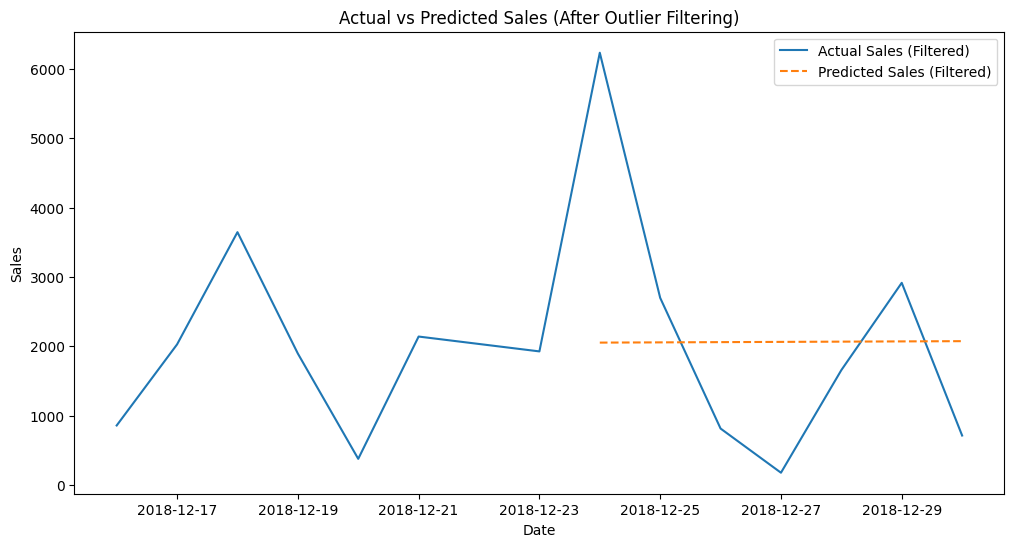

In [16]:
from sklearn.ensemble import IsolationForest

# Используем Isolation Forest для выявления выбросов
iso = IsolationForest(contamination=0.05, random_state=42)
y_outliers = iso.fit_predict(np.array(y).reshape(-1, 1))

# Фильтруем данные, убирая выбросы
mask = y_outliers != -1
X_filtered = X[mask]
y_filtered = y[mask]

# Разделяем отфильтрованные данные на обучающую и тестовую выборки
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filtered, y_filtered, test_size=7, shuffle=False)

# Обучаем модель линейной регрессии на отфильтрованных данных
model_filt = LinearRegression()
model_filt.fit(X_train_filt, y_train_filt)

# Прогнозирование на тестовой выборке
y_pred_filt = model_filt.predict(X_test_filt)

# Оценка модели на отфильтрованных данных
mae_filt = mean_absolute_error(y_test_filt, y_pred_filt)
mse_filt = mean_squared_error(y_test_filt, y_pred_filt)
rmse_filt = np.sqrt(mse_filt)
r2_filt = r2_score(y_test_filt, y_pred_filt)

print(f'MAE (Filtered): {mae_filt}')
print(f'MSE (Filtered): {mse_filt}')
print(f'RMSE (Filtered): {rmse_filt}')
print(f'R^2 (Filtered): {r2_filt}')

# Визуализация прогнозов после фильтрации выбросов
plt.figure(figsize=(12, 6))
plt.plot(df_daily_sales['Order Date'][mask][-14:], np.concatenate([y_train_filt[-7:], y_test_filt]), label='Actual Sales (Filtered)')
plt.plot(df_daily_sales['Order Date'][mask][-7:], y_pred_filt, label='Predicted Sales (Filtered)', linestyle='--')
plt.title('Actual vs Predicted Sales (After Outlier Filtering)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

После фильтрации выбросов качество модели несколько улучшилось: MAE снизилась до 1509.87, MSE — до 3674897.07, а RMSE — до 1917.00, указывая на уменьшение отклонений. Коэффициент детерминации (R^2) также улучшился и достиг -0.007, приближаясь к нулю. Это свидетельствует о более точном моделировании, однако модель еще может быть усовершенствована, возможно, за счет оптимизации данных или использования более сложных методов

MAE (Custom): 1500.3759901273745
MSE (Custom): 4410675.612422874
RMSE (Custom): 2100.1608539402105
R^2 (Custom): -0.20916495304204497


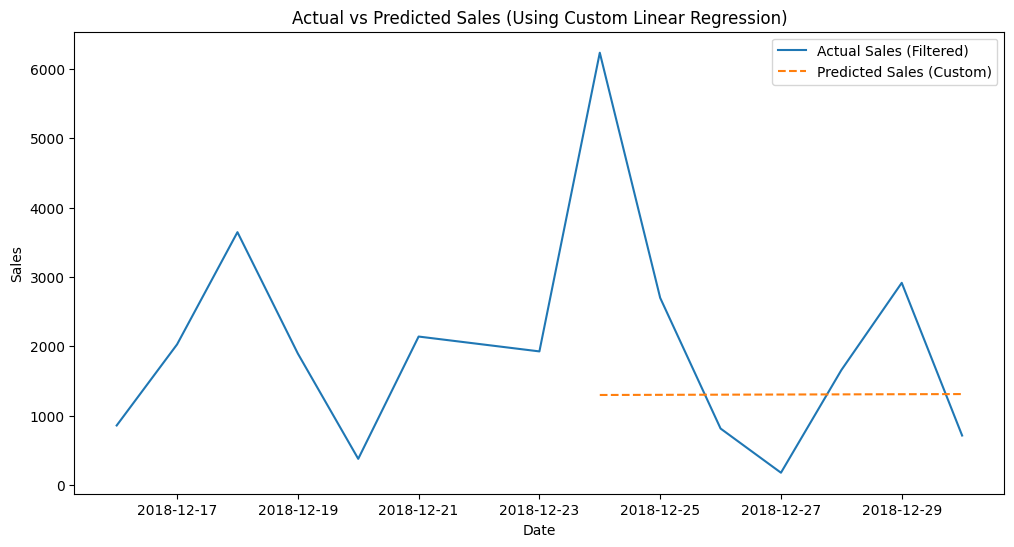

In [19]:

# Обработка и фильтрация выбросов
iso = IsolationForest(contamination=0.05, random_state=42)
y_outliers = iso.fit_predict(np.array(y).reshape(-1, 1))

mask = y_outliers != -1
X_filtered = X[mask]
y_filtered = y[mask]

# Разделяем данные на обучающую и тестовую выборки
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filtered, y_filtered, test_size=7, shuffle=False)

# Нормализация данных
scaler = StandardScaler()
X_train_filt_np = scaler.fit_transform(X_train_filt)
X_test_filt_np = scaler.transform(X_test_filt)
y_train_filt_np = np.array(y_train_filt)
y_test_filt_np = np.array(y_test_filt)

# Реализация линейной регрессии с использованием градиентного спуска
class LinearRegressionGD:
    def __init__(self, learning_rate=0.001, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Инициализация параметров
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        y = np.array(y)

        # Градиентный спуск
        for _ in range(self.n_iterations):
            y_predicted = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Обучаем собственную модель линейной регрессии
model_custom = LinearRegressionGD(learning_rate=0.001, n_iterations=1000)
model_custom.fit(X_train_filt_np, y_train_filt_np)

# Прогнозирование
y_pred_custom = model_custom.predict(X_test_filt_np)

# Оценка модели
mae_custom = mean_absolute_error(y_test_filt_np, y_pred_custom)
mse_custom = mean_squared_error(y_test_filt_np, y_pred_custom)
rmse_custom = np.sqrt(mse_custom)
r2_custom = r2_score(y_test_filt_np, y_pred_custom)

print(f'MAE (Custom): {mae_custom}')
print(f'MSE (Custom): {mse_custom}')
print(f'RMSE (Custom): {rmse_custom}')
print(f'R^2 (Custom): {r2_custom}')

# Визуализация прогнозов
plt.figure(figsize=(12, 6))
plt.plot(df_daily_sales['Order Date'][mask][-14:], np.concatenate([y_train_filt_np[-7:], y_test_filt_np]), label='Actual Sales (Filtered)')
plt.plot(df_daily_sales['Order Date'][mask][-7:], y_pred_custom, label='Predicted Sales (Custom)', linestyle='--')
plt.title('Actual vs Predicted Sales (Using Custom Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

MAE (Polynomial): 1531.514723919117
MSE (Polynomial): 3674254.874285219
RMSE (Polynomial): 1916.8345975292752
R^2 (Polynomial): -0.007278841821033888


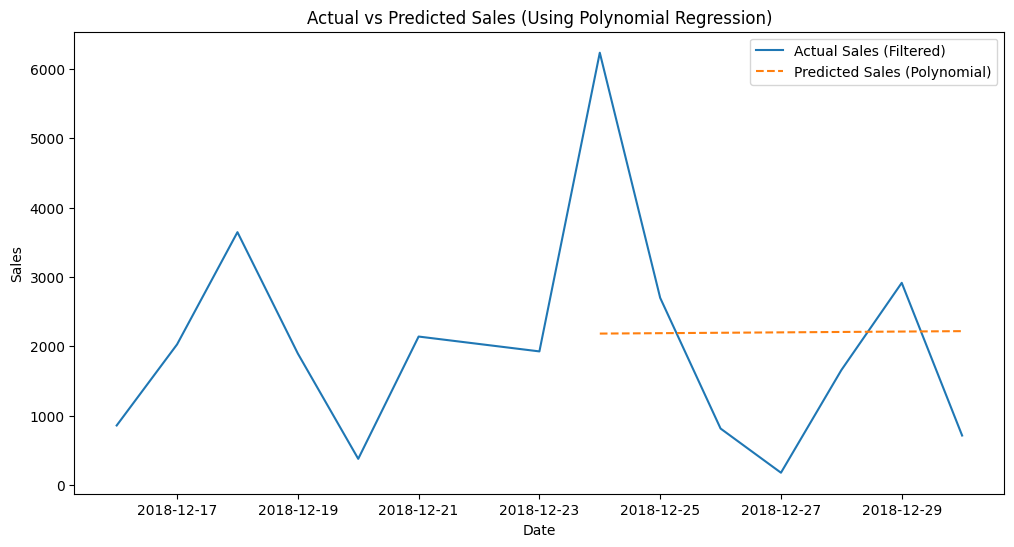

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Обучение модели на обучающей выборке
polyreg.fit(X_train_filt_np, y_train_filt_np)

# Прогнозирование на тестовой выборке
y_pred_poly = polyreg.predict(X_test_filt_np)

# Оценка модели
mae_poly = mean_absolute_error(y_test_filt_np, y_pred_poly)
mse_poly = mean_squared_error(y_test_filt_np, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test_filt_np, y_pred_poly)

print(f'MAE (Polynomial): {mae_poly}')
print(f'MSE (Polynomial): {mse_poly}')
print(f'RMSE (Polynomial): {rmse_poly}')
print(f'R^2 (Polynomial): {r2_poly}')

# Визуализация прогнозов
plt.figure(figsize=(12, 6))
plt.plot(df_daily_sales['Order Date'][mask][-14:], np.concatenate([y_train_filt_np[-7:], y_test_filt_np]), label='Actual Sales (Filtered)')
plt.plot(df_daily_sales['Order Date'][mask][-7:], y_pred_poly, label='Predicted Sales (Polynomial)', linestyle='--')
plt.title('Actual vs Predicted Sales (Using Polynomial Regression)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Добавление полиномиальных признаков улучшило точность модели: RMSE снизился до 1916.83, а коэффициент детерминации R² стал ближе к нулю, составляя -0.007. Это свидетельствует о лучшем учете зависимости в данных по сравнению с линейной моделью, хотя и недостаточно для достижения положительного R²